<div style="font-family: sans-serif; font-size: 4em; text-align: center; font-weight: bold;">VISUALIZATION OF FLIGHT DELAYS</div>

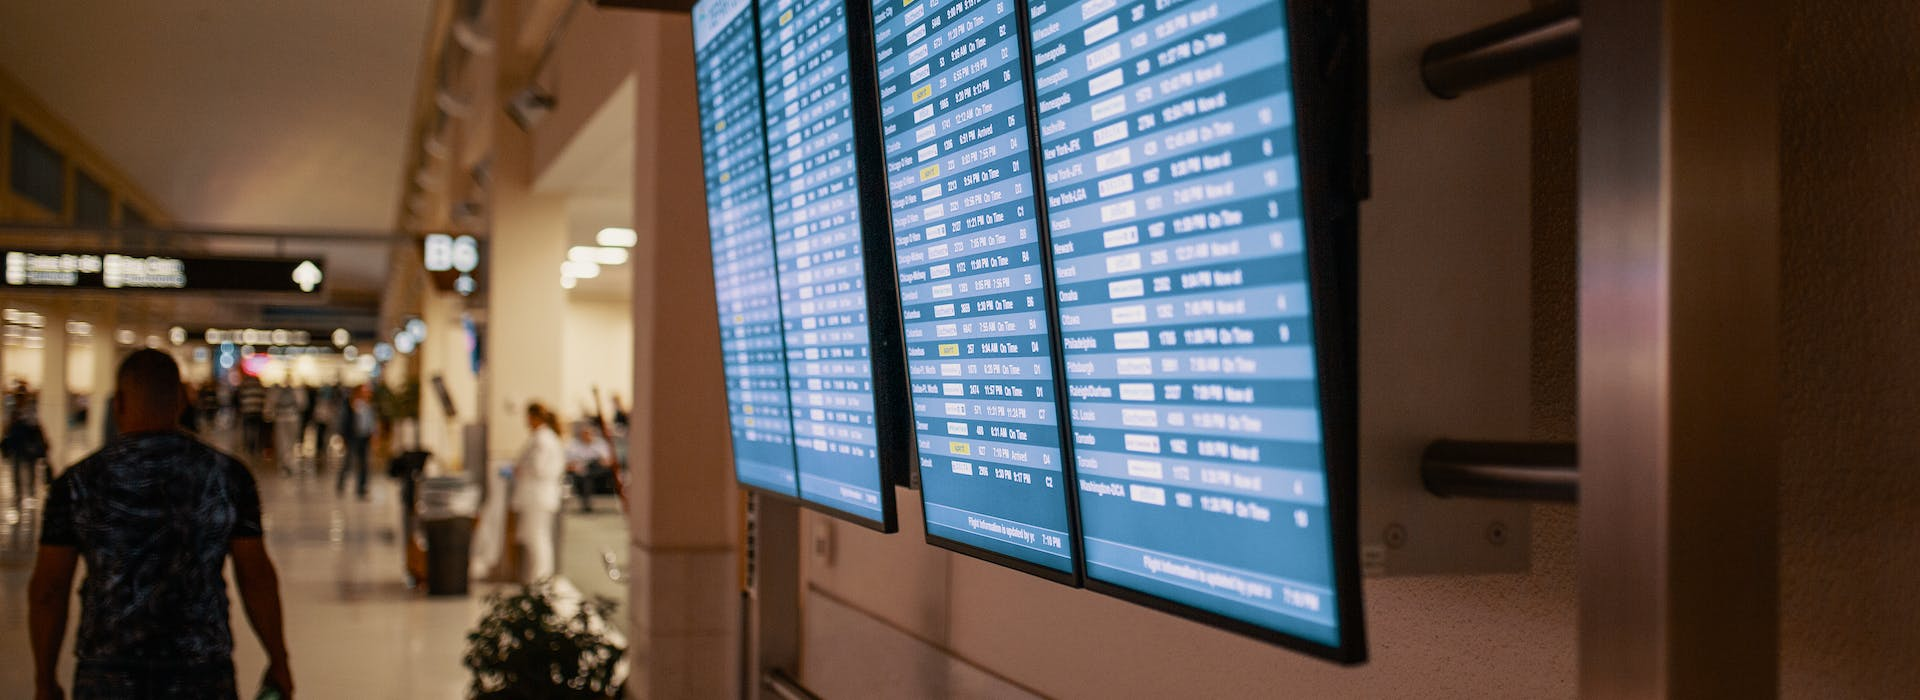

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

sns.set_palette('rocket')

# Read and Process Data

In [2]:
class DataProcessor:
    folder = '/kaggle/input/flight-delay-and-cancellation-dataset-2019-2023'
    
    col_renamer = {
        'FL_DATE': 'flight_date',
        'AIRLINE_CODE': 'airline_code',
        'ORIGIN': 'origin_airport',
        'ORIGIN_CITY': 'origin_city',
        'DEST': 'destination_airport',
        'DEST_CITY': 'destination_city',
        'CRS_DEP_TIME': 'scheduled_departure_time',
        'DEP_DELAY': 'departure_delay',
        'TAXI_OUT': 'taxi_out',
        'TAXI_IN': 'taxi_in',
        'ARR_DELAY': 'arrival_delay',
        'CANCELLED': 'is_cancelled',
        'CANCELLATION_CODE': 'cancellation_code',
        'AIR_TIME': 'air_time',
        'DISTANCE': 'distance_in_miles'
    }
    
    def __init__(self):
        pass
    
    def _read_data(self, year):
        print(f'Reading year data for {year}...', end=' ')
        self.data = pd.read_csv(f'{DataProcessor.folder}/{year}.csv')
        
    def _fix_colnames(self):
        wanted_columns = list(DataProcessor.col_renamer.keys())
        self.data = self.data[wanted_columns]  # remove unccessary columns
        self.data = self.data.rename(columns=DataProcessor.col_renamer)  # rename column names
        
    def fix_dtypes(self):
        self.data['flight_date'] = pd.to_datetime(self.data['flight_date'])
        self.data['is_cancelled'] = self.data['is_cancelled'].astype(bool)
        self.data['distance_in_miles'] = self.data['distance_in_miles'].astype(int)
    
    def _create_new_columns(self, year):
        self.data['scheduled_departure_hour'] = self.data['scheduled_departure_time']//100
        self.data['year'] = year
        
    def get_processed_year_data(self, year):
        self._read_data(year)
        print('Processing data...', end=' ')
        self._fix_colnames()
        self.fix_dtypes()
        self._create_new_columns(year)
        print('Finished')
        return self.data

In [3]:
categorical_features = [
'flight_date', 'airline_code', 'origin_airport', 'origin_city', 
'destination_airport', 'destination_city', 'cancellation_code', 'year'
]

num_features = [
'scheduled_departure_time', 'departure_delay', 'taxi_out', 'taxi_in', 'arrival_delay', 
'air_time', 'distance_in_miles', 'scheduled_departure_hour'
]

def postprocess(data):
    print('Postprocessing categorical features...')
    for col in tqdm(categorical_features):
        data[col] = data[col].astype('category')
     
    print('Postprocessing numerical features...')
    for col in tqdm(num_features):
        data[col] = data[col].astype('float32')
        
    return data

In [4]:
processor = DataProcessor()

data = []
for year in range(2019, 2024):
    this_year_data = processor.get_processed_year_data(year)
    data.append(this_year_data)
    del this_year_data
    
data = pd.concat(data).reset_index(drop=True)

data = postprocess(data)

Reading year data for 2019... Processing data... Finished
Reading year data for 2020... Processing data... Finished
Reading year data for 2021... Processing data... Finished
Reading year data for 2022... Processing data... Finished
Reading year data for 2023... Processing data... Finished
Postprocessing categorical features...


  0%|          | 0/8 [00:00<?, ?it/s]

Postprocessing numerical features...


  0%|          | 0/8 [00:00<?, ?it/s]

# A quick look to the data

In [5]:
print(f'The data has {data.shape[0]} rows and {data.shape[1]} columns.')

The data has 29380335 rows and 17 columns.


Let's look at 5 sample rows.

In [6]:
data.sample(5, random_state=0)

,flight_date,airline_code,origin_airport,origin_city,destination_airport,destination_city,scheduled_departure_time,departure_delay,taxi_out,taxi_in,arrival_delay,is_cancelled,cancellation_code,air_time,distance_in_miles,scheduled_departure_hour,year
20261563,2022-07-19,YX,MHT,"Manchester, NH",EWR,"Newark, NJ",700.0,-4.0,9.0,33.0,-1.0,False,Z,46.0,209.0,7.0,2022
4780403,2019-04-16,DL,DEN,"Denver, CO",LAX,"Los Angeles, CA",1445.0,-6.0,18.0,13.0,-6.0,False,Z,119.0,862.0,14.0,2019
24055547,2022-12-02,UA,EWR,"Newark, NJ",SFO,"San Francisco, CA",1530.0,149.0,19.0,6.0,155.0,False,Z,360.0,2565.0,15.0,2022
27273648,2023-01-09,B6,ORH,"Worcester, MA",JFK,"New York, NY",1615.0,-12.0,9.0,5.0,-23.0,False,Z,39.0,150.0,16.0,2023
24521644,2022-08-29,B6,JFK,"New York, NY",ACK,"Nantucket, MA",915.0,-9.0,16.0,5.0,-17.0,False,Z,42.0,199.0,9.0,2022


# Delay Distribution over the Year

In [7]:
delay_distribution = (
    data
    .assign(flight_day = data.flight_date.map(lambda x: str(x)[5:10]), is_delayed = data.departure_delay >= 60)
    .groupby('flight_day')
    .is_delayed.mean()
    .rolling(7, min_periods=1, center=True)
    .mean()
)

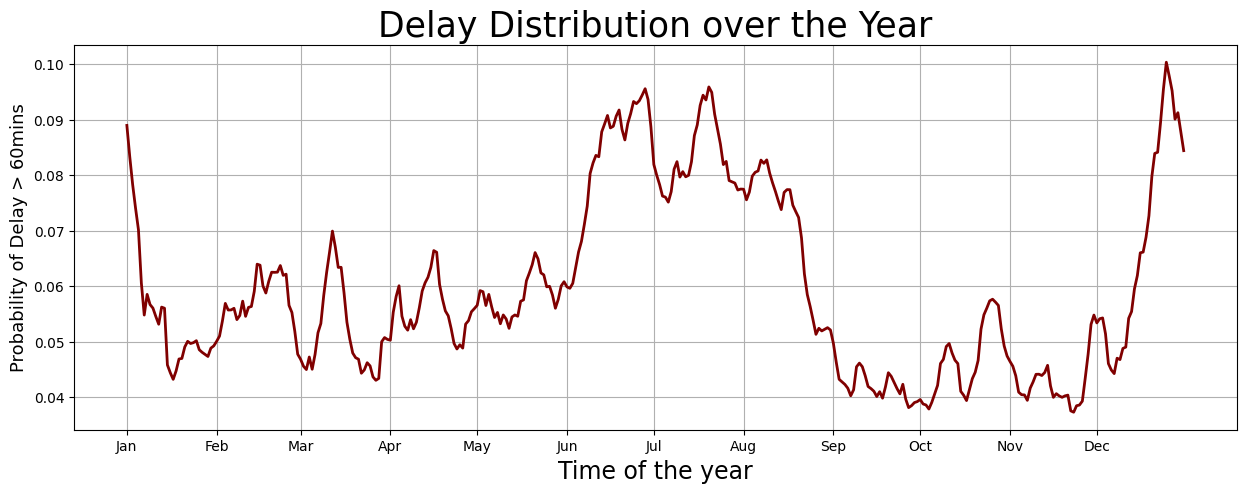

In [8]:
plt.figure(figsize=(15,5))
plt.plot(delay_distribution, color='maroon', linewidth=2)
month_starts = [f'{str(i).zfill(2)}-01' for i in range(1, 13)]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(month_starts, labels=month_names)
plt.grid()
plt.title('Delay Distribution over the Year', fontsize=25)
plt.xlabel('Time of the year', fontsize=17)
plt.ylabel('Probability of Delay > 60mins', fontsize=13)
plt.show()

# Visualization of Departure & Arrival Delays

Below we can see that most flights has delays up to 1 hour. Please pay attention to the **log scale on the y-axis.**

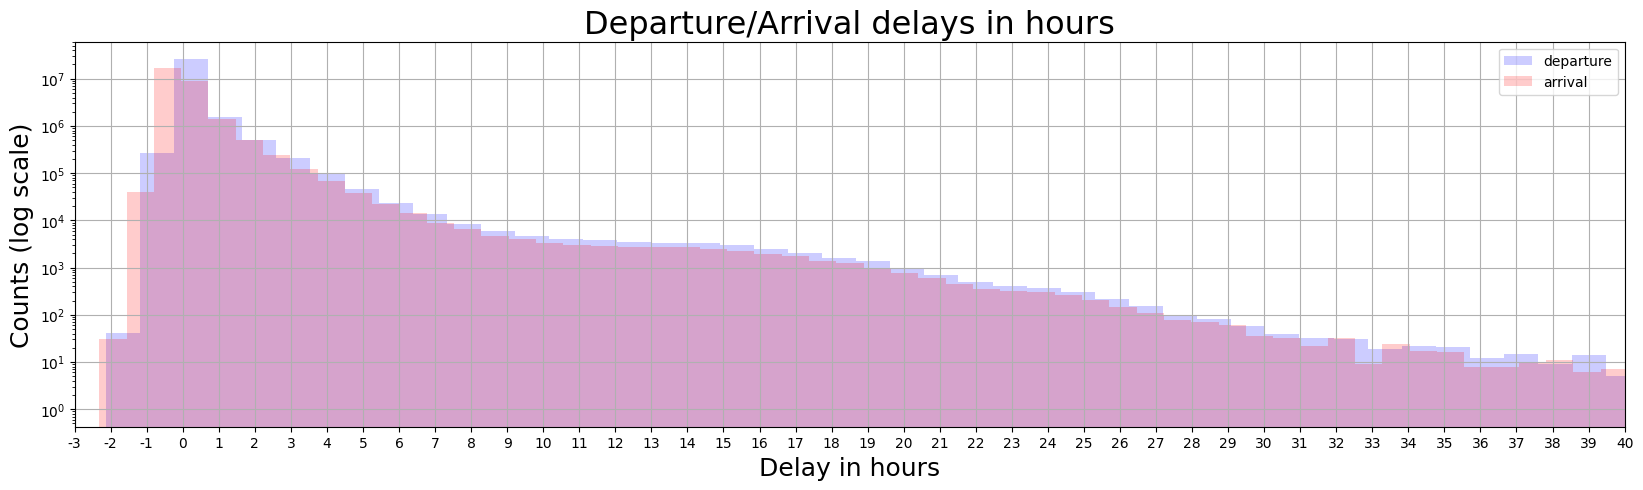

In [9]:
plt.figure(figsize=(20, 5))
plt.hist(data['departure_delay'], bins=80, label='departure', alpha=.2, color='blue')
plt.hist(data['arrival_delay'], bins=100, label='arrival', alpha=.2, color='red')
plt.yscale("log")
plt.xticks(np.arange(-180, 2401, 60), labels=np.arange(-180, 2401, 60)//60)
plt.xlim(-180, 2400)
plt.xlabel('Delay in hours', fontsize=18)
plt.ylabel('Counts (log scale)', fontsize=18)
plt.title('Departure/Arrival delays in hours', fontsize=23)
plt.legend()
plt.grid()
plt.show()

As can be seen below, 65.1% of the flights had a negative departure delay about up to 15 minutes. (-.25, 0]

In other words, around 65% of the flights departed up to 15 earlier.

5.3 % of the flights departed 30min-60min late,

5.0 % of the flights departed 60min-180min late.

In [10]:
delay_hours = [-.5, -.25, 0, .25, .5, 1, 3, 6, 12, 24, 100000]

(
    (pd.cut(data['departure_delay']/60, delay_hours)
     .value_counts(normalize=True)
     .sort_index()*100)
    .round(1)
    .map(lambda x: f'{x} %')
    .reset_index()
)

,departure_delay,proportion
0,"(-0.5, -0.25]",0.9 %
1,"(-0.25, 0.0]",65.1 %
2,"(0.0, 0.25]",16.4 %
3,"(0.25, 0.5]",6.1 %
4,"(0.5, 1.0]",5.3 %
5,"(1.0, 3.0]",5.0 %
6,"(3.0, 6.0]",0.9 %
7,"(6.0, 12.0]",0.2 %
8,"(12.0, 24.0]",0.1 %
9,"(24.0, 100000.0]",0.0 %


# Cities with most delays

Among the flights with departure delays greater than 60 minutes, approximately 6% of them were from Chicago. This was followed by Dallas and New York.

In [11]:
(
    (
        data
        .query('departure_delay >= 60')
        .origin_city
        .value_counts(normalize=True)
        .head(10)*100
    )
    .round(2)
    .reset_index()
    .rename(columns={'proportion': 'percent'})
)

,origin_city,percent
0,"Chicago, IL",5.95
1,"Dallas/Fort Worth, TX",5.30
2,"New York, NY",4.90
3,"Denver, CO",4.71
4,"Atlanta, GA",3.94
5,"Charlotte, NC",3.14
6,"Houston, TX",3.10
7,"Orlando, FL",3.03
8,"Washington, DC",2.80
9,"Newark, NJ",2.69


# Departure is delayed $\stackrel{?}{\implies}$ Arrival is delayed

It is reasonable to expect that departure delays cause arrival delays. Let's look at the correlation between them.

In [12]:
corr = data.departure_delay.corr(data.arrival_delay).round(3)*100
print(f'The correlation between departure delay and arrival delay is {corr}%')

The correlation between departure delay and arrival delay is 96.5%


Let's look at the scatterplot:

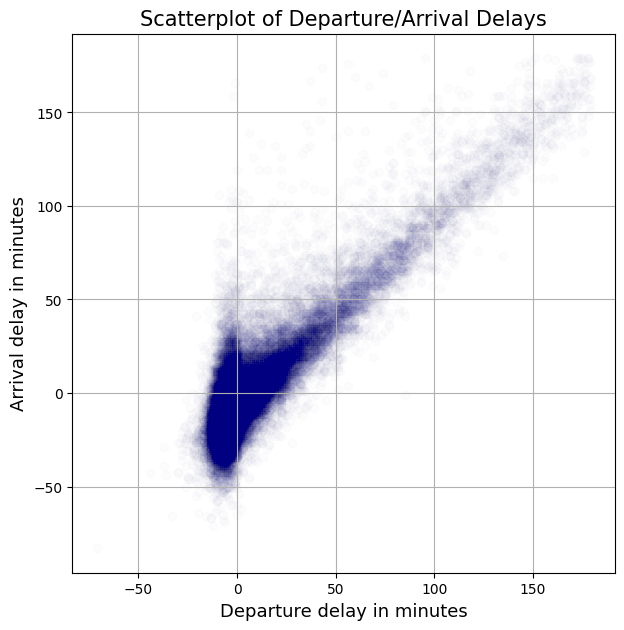

In [13]:
plt.figure(figsize=(7, 7))
sample = data.query('departure_delay < 180 & arrival_delay < 180').sample(50000, random_state=0)
plt.scatter(sample.departure_delay, sample.arrival_delay, c='navy', alpha=.01)
del sample
plt.grid()
plt.xlabel('Departure delay in minutes', fontsize=13)
plt.ylabel('Arrival delay in minutes', fontsize=13)
plt.title('Scatterplot of Departure/Arrival Delays', fontsize=15)
plt.show()

# Distance vs Air Time

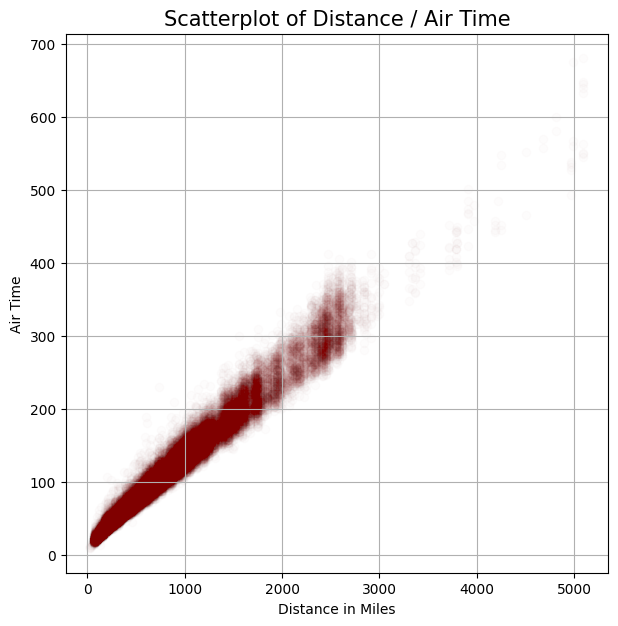

In [14]:
plt.figure(figsize=(7, 7))
sample = data.sample(50000, random_state=0)
plt.scatter(sample.distance_in_miles, sample.air_time, alpha=.01, c='maroon')
del sample
plt.grid()
plt.xlabel('Distance in Miles')
plt.ylabel('Air Time')
plt.title('Scatterplot of Distance / Air Time', fontsize=15)
plt.show()

# Distance in Miles

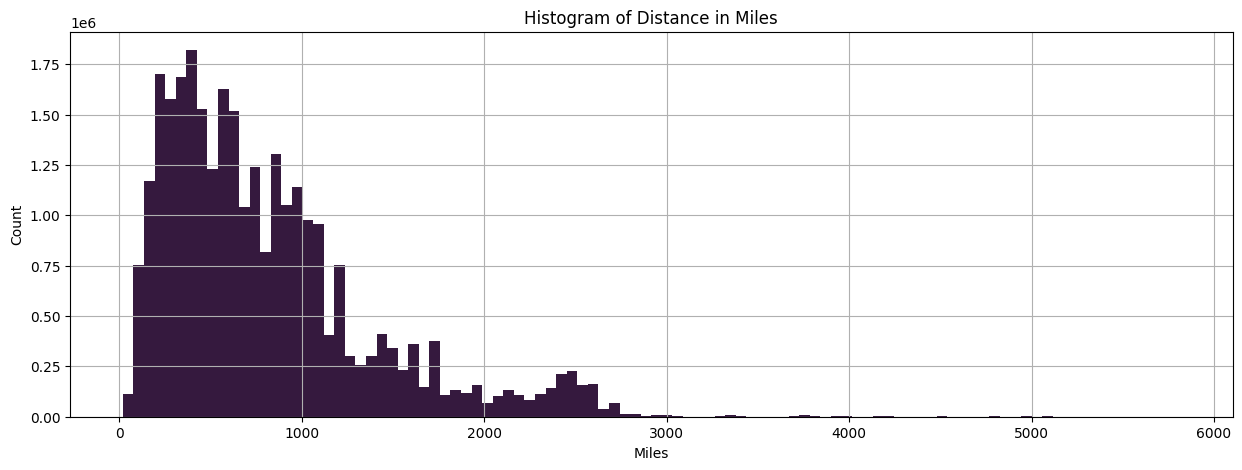

In [15]:
data.distance_in_miles.plot.hist(bins=100, figsize=(15,5), grid=True, 
                                 xlabel='Miles', ylabel='Count', title='Histogram of Distance in Miles')
plt.show()